[View in Colaboratory](https://colab.research.google.com/github/taiki323/kaggle_training/blob/master/Stacking(TITANIC).ipynb)

>[セットアップ](#scrollTo=48U-RYvdEw8O)

>[前処理](#scrollTo=C7bDGsJNzGoR)

>>[データ加工](#scrollTo=WPnzMP5huLiz)

>>[統計分析](#scrollTo=E7S-ef3VuPfP)

>>>[ヒートマップ](#scrollTo=s8skKl_3vxBW)

>>>[PairPlots](#scrollTo=FdKZr4Fc2TZI)

>[Stacking](#scrollTo=FsYjVWHy_lHz)

>>[stacking model](#scrollTo=2Bn76TXRFrKJ)

>>[out-of-fold prediction](#scrollTo=Y3_wZOalFumm)

>[Generate First Models](#scrollTo=q_PlNqt8HTBz)

>>[parameters](#scrollTo=I4hR8OMCiSB_)

>>[create models](#scrollTo=g7i5VnrwjWrf)



#セットアップ0

In [0]:
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
dir_id = "1Aw6yxQfQTGPgsG92DWAZyzCi60oiiPqR"

# フォルダ内にあるファイル名とファイルIDを表示する
file_list = drive.ListFile({'q': "'%s' in parents and trashed=false" % dir_id}).GetList()
for f in file_list:
  print("name: " + f["title"] + ", id: " + f["id"])

In [0]:
# 上記の方法で調べたファイルのID
file_id = "1wBnUryXDAFfa6miy-YwRVOvhWcTfVSKY"
drive_file = drive.CreateFile({'id': file_id})

# ファイルの取得
drive_file.GetContentFile("train.csv")

with open("train.csv", "r") as f:
  file_string = f.read()

file_string

In [0]:
# 上記の方法で調べたファイルのID
file_id = "19erwo4If6zvlj_CzJ74ioKlWeOq5IW_M"
drive_file = drive.CreateFile({'id': file_id})

# ファイルの取得
drive_file.GetContentFile("test.csv")

with open("test.csv", "r") as f:
  file_string = f.read()

file_string

# セットアップ

In [4]:
!pip install kaggle　
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth

auth.authenticate_user()

drive_service = build('drive', 'v3')
results = drive_service.files().list(
        q="name = 'kaggle.json'", fields="files(id)").execute()
kaggle_api_key = results.get('files', [])

filename = "/content/.kaggle/kaggle.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)

request = drive_service.files().get_media(fileId=kaggle_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)

    100% |████████████████████████████████| 61kB 4.0MB/s 
    100% |████████████████████████████████| 235kB 7.8MB/s 
  Running setup.py bdist_wheel for kaggle ... - \ done
  Stored in directory: /root/.cache/pip/wheels/44/2c/df/22a6eeb780c36c28190faef6252b739fdc47145fd87a6642d4
  Running setup.py bdist_wheel for python-slugify ... - done
  Stored in directory: /root/.cache/pip/wheels/e3/65/da/2045deea3098ed7471eca0e2460cfbd3fdfe8c1d6fa6fcac92
Successfully built kaggle python-slugify
Download 100%.


In [5]:
# !mkdir .kaggle
!mkdir ~/.kaggle
!mkdir work
%cd work
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json
!kaggle competitions download -c titanic

/content/work
  0% 0.00/59.8k [00:00<?, ?B/s]
100% 59.8k/59.8k [00:00<00:00, 29.5MB/s]
  0% 0.00/28.0k [00:00<?, ?B/s]
100% 28.0k/28.0k [00:00<00:00, 22.9MB/s]
  0% 0.00/3.18k [00:00<?, ?B/s]
100% 3.18k/3.18k [00:00<00:00, 3.88MB/s]


# 前処理

## データ加工

In [6]:
import pandas as pd
import numpy as np
import re
import sklearn
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

import warnings
warnings.filterwarnings('ignore')

# Going to use these 5 base models for the stacking
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.svm import SVC
from sklearn.cross_validation import KFold


In [0]:
train = pd.read_csv("/content/work/train.csv")
test = pd.read_csv("/content/work/test.csv")

PassengerId = test["PassengerId"]

In [0]:
full_data = [train, test]
train['Name_length'] = train['Name'].apply(len)
test['Name_length']  = train['Name'].apply(len)

train['Has_Cabin'] = train["Cabin"].apply(lambda x: 0 if type(x) == float else 1)
test['Has_Cabin'] = test["Cabin"].apply(lambda x: 0 if type(x) == float else 1)

#家族人数
for dataset in full_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1

#一人なら1
for dataset in full_data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1

# Embarkedのnull埋め
for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')

# Fareのnull埋め 全体数を4分割
for dataset in full_data:
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())
train['CategoricalFare'] = pd.qcut(train['Fare'], 4)    

# Ageのnull埋め　平均±標準偏差
for dataset in full_data:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)
train['CategoricalAge'] = pd.cut(train['Age'], 5)

# NameからMr, Ms等を抽出
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""
  
for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)
    
for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

In [0]:
#文字変数を数値に変換
for dataset in full_data:
    # Mapping Sex
    dataset['Sex'] = dataset['Sex'].map( {'female': 0, 'male': 1} ).astype(int)
    
    # Mapping titles
    title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)
    
    # Mapping Embarked
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
    
    # Mapping Fare
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] 						        = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] 							        = 3
    dataset['Fare'] = dataset['Fare'].astype(int)
    
    # Mapping Age
    dataset.loc[ dataset['Age'] <= 16, 'Age'] 					       = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age'] = 4 ;

In [0]:
# Feature selection
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp']
train = train.drop(drop_elements, axis = 1)
train = train.drop(['CategoricalAge', 'CategoricalFare'], axis = 1)
test  = test.drop(drop_elements, axis = 1)

## 統計分析

### ヒートマップ

各説明変数間の相関が強いものが無いため、良い特徴である。

なぜなら、余計なデータが無くそれぞれがユニークな情報を持っているためである。

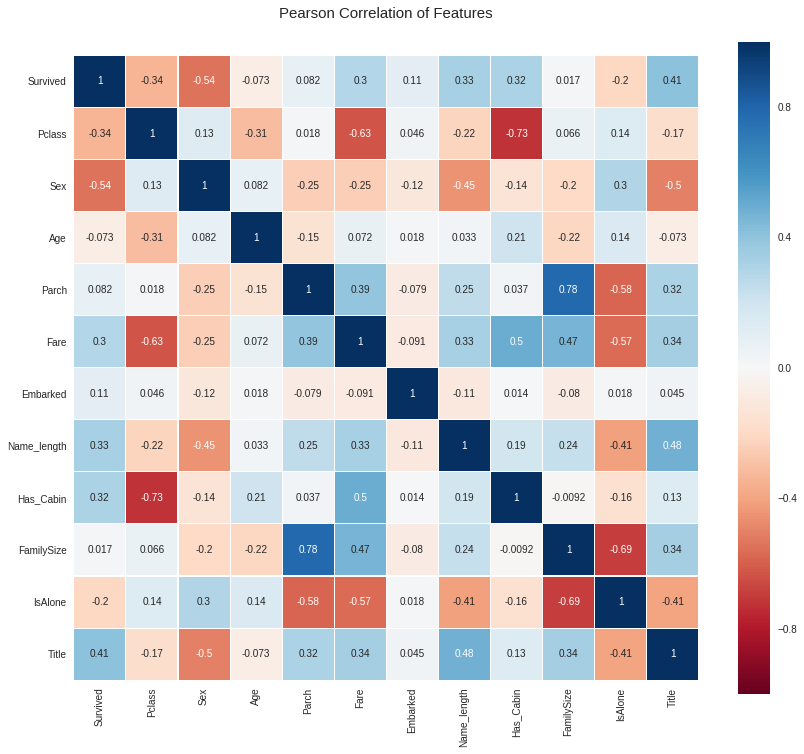

In [11]:

colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

### PairPlots

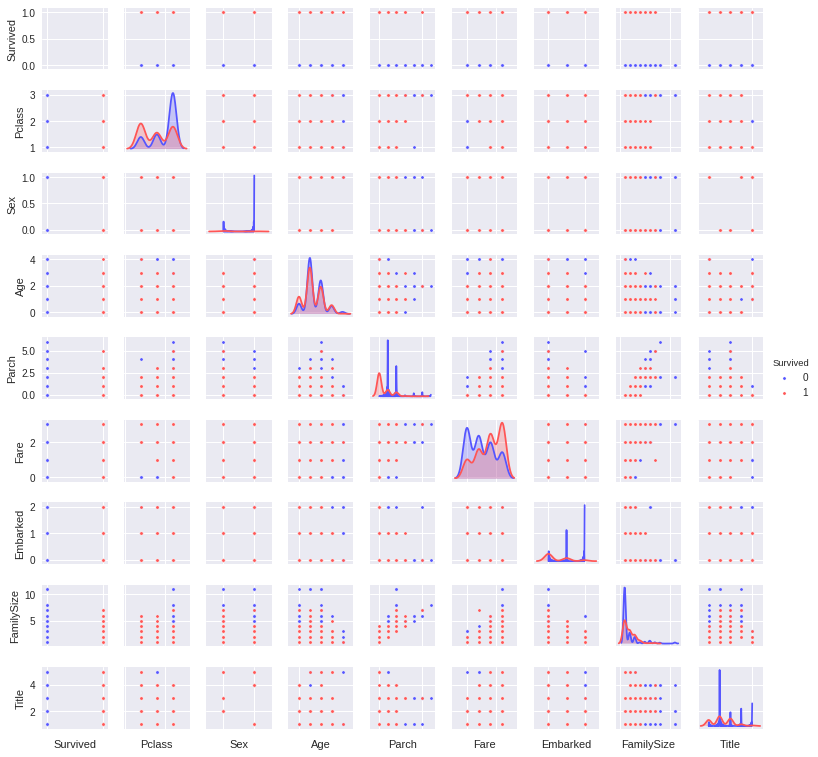

In [12]:
g = sns.pairplot(train[[u'Survived', u'Pclass', u'Sex', u'Age', u'Parch', u'Fare', u'Embarked',
       u'FamilySize', u'Title']], hue='Survived', palette = 'seismic',size=1.2,diag_kind = 'kde',diag_kws=dict(shade=True),plot_kws=dict(s=10) )
g.set(xticklabels=[])

# Stacking

1. 学習データにクロスバリデーション用いてレベル1モデル学習。CV=5なら、モデルを5つ作成。学習データに対して1/5ずつ[0,1]で予測(①)。
テストデータに対して各モデル(5個)で予測し、平均を取る(②)。これがレベル2の入力データになる。
これを学習器5個に適応。

2. 学習器5個の学習データに対する予測値(①)と学習データの正解ラベルを用いてレベル2モデル学習。

3. ②のデータ(小数)を入力にして、レベル2モデルで予測する。


## stacking model

In [0]:
ntrain = train.shape[0]
ntest = test.shape[0]

SEED = 0
NFOLDS = 5
kf = KFold(ntrain, n_folds= NFOLDS, random_state=SEED)  #cv 5分割

class SklearnHelper(object):
  def __init__(self, clf, seed=0, params=None):
      params['random_state'] = seed
      self.clf = clf(**params)
  
  def train(self, x_train, y_train):
    self.clf.fit(x_train, y_train)
    
  def predict(self, x):
    return self.clf.predict(x)
  
  def fit(self, x, y):
    return self.clf.fit(x, y)
  
  def feature_importances(self, x, y):
    return self.clf.fit(x, y).feature_importances_

## out-of-fold prediction


In [0]:
def get_oof(clf, x_train, y_train, x_test):
  oof_train = np.zeros((ntrain,))
  oof_test = np.zeros((ntest,))
  oof_test_skf = np.empty((NFOLDS, ntest)) #(5, 418)
  
  # train_index=(713,)*5 test_index=(178,)*5
  #1週目はtest=[0~178], train=[179~890]
  for i, (train_index, test_index) in enumerate(kf): 
    x_tr = x_train[train_index]
    y_tr = y_train[train_index]
    x_te = x_train[test_index]
    
    clf.train(x_tr, y_tr)
    
    oof_train[test_index] = clf.predict(x_te) #ベースモデルのtrainデータに対する予測結果
    oof_test_skf[i, :] = clf.predict(x_test)  #ベースモデルのtestデータに対する予測結果
  
  oof_test[:] = oof_test_skf.mean(axis=0) #縦の平均　各データの各モデルの予測結果の平均
  #ベースモデルの全trainデータに対する予測結果, 5つのベースモデルのテストデータに対する予測の平均
  return oof_train.reshape(-1,1), oof_test.reshape(-1,1) 

# Generate First Models

## parameters

In [0]:
# Random Forest parameters
rf_params = {
    'n_jobs': -1,
    'n_estimators': 500,
     'warm_start': True, 
     #'max_features': 0.2,
    'max_depth': 6,
    'min_samples_leaf': 2,
    'max_features' : 'sqrt',
    'verbose': 0
}

# Extra Trees Parameters
et_params = {
    'n_jobs': -1,
    'n_estimators':500,
    #'max_features': 0.5,
    'max_depth': 8,
    'min_samples_leaf': 2,
    'verbose': 0
}

# AdaBoost parameters
ada_params = {
    'n_estimators': 500,
    'learning_rate' : 0.75
}

# Gradient Boosting parameters
gb_params = {
    'n_estimators': 500,
     #'max_features': 0.2,
    'max_depth': 5,
    'min_samples_leaf': 2,
    'verbose': 0
}

# Support Vector Classifier parameters 
svc_params = {
    'kernel' : 'linear',
    'C' : 0.025
    }

In [0]:
# Create 5 objects that represent our 4 models
rf = SklearnHelper(clf=RandomForestClassifier, seed=SEED, params=rf_params)
et = SklearnHelper(clf=ExtraTreesClassifier, seed=SEED, params=et_params)
ada = SklearnHelper(clf=AdaBoostClassifier, seed=SEED, params=ada_params)
gb = SklearnHelper(clf=GradientBoostingClassifier, seed=SEED, params=gb_params)
svc = SklearnHelper(clf=SVC, seed=SEED, params=svc_params)

## create models

In [0]:
y_train = train['Survived'].ravel()
train = train.drop(['Survived'], axis=1)
x_train = train.values 
x_test = test.values

In [0]:
# Create our OOF train and test predictions. These base results will be used as new features
et_oof_train, et_oof_test = get_oof(et, x_train, y_train, x_test) # Extra Trees
rf_oof_train, rf_oof_test = get_oof(rf,x_train, y_train, x_test) # Random Forest
ada_oof_train, ada_oof_test = get_oof(ada, x_train, y_train, x_test) # AdaBoost 
gb_oof_train, gb_oof_test = get_oof(gb,x_train, y_train, x_test) # Gradient Boost
svc_oof_train, svc_oof_test = get_oof(svc,x_train, y_train, x_test) # Support Vector Classifier

In [0]:
rf_features = rf.feature_importances(x_train,y_train).tolist()
et_features = et.feature_importances(x_train, y_train).tolist()
ada_features = ada.feature_importances(x_train, y_train).tolist()
gb_features = gb.feature_importances(x_train,y_train).tolist()

In [0]:
cols = train.columns.values
# Create a dataframe with features
feature_dataframe = pd.DataFrame( {'features': cols,
     'Random Forest feature importances': rf_features,
     'Extra Trees  feature importances': et_features,
      'AdaBoost feature importances': ada_features,
    'Gradient Boost feature importances': gb_features
    })

In [21]:
feature_dataframe['mean'] = feature_dataframe.mean(axis= 1) # axis = 1 computes the mean row-wise
feature_dataframe.head(3)

,AdaBoost feature importances,Extra Trees feature importances,Gradient Boost feature importances,Random Forest feature importances,features,mean
0,0.028,0.120456,0.080069,0.124033,Pclass,0.088140
1,0.012,0.380300,0.037060,0.199334,Sex,0.157174
2,0.020,0.028487,0.093725,0.032236,Age,0.043612


# Generate Second Models

In [22]:
base_predictions_train = pd.DataFrame( {'RandomForest': rf_oof_train.ravel(),
     'ExtraTrees': et_oof_train.ravel(),
     'AdaBoost': ada_oof_train.ravel(),
      'GradientBoost': gb_oof_train.ravel()
    })
base_predictions_train.head()

,AdaBoost,ExtraTrees,GradientBoost,RandomForest
0,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,1.0
2,1.0,0.0,1.0,1.0
3,1.0,1.0,1.0,1.0
4,0.0,0.0,0.0,0.0


Secondレベルの入力値の相関

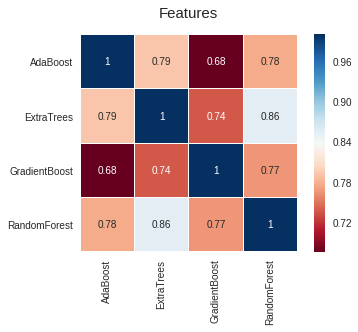

In [23]:
colormap = plt.cm.RdBu
plt.title('Features', y=1.05, size=15)
sns.heatmap(base_predictions_train.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

In [24]:
np.concatenate(( et_oof_test, rf_oof_test, ada_oof_test, gb_oof_test, svc_oof_test), axis=1)

array([[0. , 0. , 0. , 0. , 0. ],
       [0.8, 1. , 1. , 1. , 1. ],
       [0. , 0. , 0. , 0. , 0. ],
       ...,
       [0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0.6, 0. ],
       [1. , 1. , 1. , 0.6, 0.6]])

In [0]:
x_train = np.concatenate((et_oof_train, rf_oof_train, ada_oof_train, gb_oof_train, svc_oof_train), axis=1)  #(891,5)
x_test = np.concatenate(( et_oof_test, rf_oof_test, ada_oof_test, gb_oof_test, svc_oof_test), axis=1) #(418,5)

In [0]:
gbm = xgb.XGBClassifier(
    #learning_rate = 0.02,
 n_estimators= 2000,
 max_depth= 4,
 min_child_weight= 2,
 #gamma=1,
 gamma=0.9,                        
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread= -1,
 scale_pos_weight=1).fit(x_train, y_train) #学習データ 入力:First Modelsの予測結果, 学習データのラベル
predictions = gbm.predict(x_test)

In [0]:
# Generate Submission File 
StackingSubmission = pd.DataFrame({ 'PassengerId': PassengerId,
                            'Survived': predictions })
StackingSubmission.to_csv("StackingSubmission.csv", index=False)

In [29]:
!kaggle competitions submit -c titanic -f StackingSubmission.csv -m "StackingSubmission"

Successfully submitted to Titanic: Machine Learning from Disaster